In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
from sklearn.model_selection import cross_val_score

In [7]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [8]:
from statistics import mode
#check columns with categorical values if 97% are from same category then delete
low_info = [col for col in df.select_dtypes(exclude=['number']) if 1-(sum(df[col]==mode(df[col]))/len(df)) < 0.03]
low_info

['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating']

In [9]:
def df_format(data,test=False):
    df_x,df_y = pd.DataFrame(),pd.DataFrame()
    
    #add columns that are not being modified
    remove_cols = ['SalePrice','FullBath','HalfBath','BsmtFullBath','BsmtHalfBath','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating']
    df_x = data[data.columns.difference(remove_cols)]
    #add columns from old dataframe that are being collated
    bath = data['FullBath']+0.5*data['HalfBath']+data['BsmtFullBath']+0.5*data['BsmtHalfBath']
    porchsf = data[['WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch']].sum(axis=1)
    ag = {'Bath':bath,'PorchSF':porchsf}
    df_x = pd.concat([df_x,pd.concat(ag,axis=1)],axis=1)
    
    df_x = df_x.fillna(df_x.median())
    
    if test == False:
        df_y = np.log(data[['SalePrice']])
        return df_x,df_y
    else:
        return df_x

In [10]:
def get_final(dt):
    df_submit = pd.DataFrame({'Id':range(1461,2920)})
    df_submit['SalePrice'] = np.exp(pd.DataFrame(dt))
    return df_submit

In [11]:
df_x,df_y = df_format(df)
df_test_x = df_format(df_test,True)

# add columns that were not present in df_test_x but in df_x
# for cols in df_x.columns.difference(df_test_x.columns):
#     df_test_x[cols] = 0

In [12]:
df_all = pd.concat([df_x,df_test_x],axis=0)

In [13]:
# Convert numeric columns to categorical
df_all.MSSubClass = df_all.MSSubClass.astype(str)

# One-hot encoding
df_all = pd.get_dummies(df_all)
keep_cols = df_all.select_dtypes(include=['number']).columns
df_all = df_all[keep_cols]

# Converting YEAR to years-old
for c in ['GarageYrBlt','YearBuilt','YearRemodAdd', 'YrSold']:
    df_all[c] = df_all[c].apply(lambda x:2017-x)

In [ ]:
# Min-Max Scaling on features & convert to numpy arrays(internally)
from sklearn import preprocessing

minmax_scale = preprocessing.MinMaxScaler().fit(df_all)
df_minmax = minmax_scale.transform(df_all)

df_x = df_minmax[0:len(df_x)]
df_y = np.array(df_y)
df_test_x = df_minmax[-len(df_test_x):]

In [14]:
# if using only One-hot encoding
df_x = df_all[0:len(df_x)]
df_test_x = df_all[-len(df_test_x):]

In [ ]:
keep_cols

In [ ]:
df_y.shape

In [ ]:
df_test_x.shape

In [ ]:
f, (ax1,ax2) = plt.subplots(nrows=1,ncols=2, sharey=True)

### Descision Tree Regressor

In [33]:
from sklearn.tree import DecisionTreeRegressor
# from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import KFold
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)

In [34]:
x_axis,y_axis,z_axis = [],[],[]
for j in range(2,21):
    regression_tree = DecisionTreeRegressor(min_samples_split=20, min_samples_leaf=j,random_state=0)
    reg_fit = regression_tree.fit(df_x,df_y)
    cv_scores = cross_val_score(cv=crossvalidation,X=df_x,y=df_y,estimator=reg_fit)
    x_axis.append(j)
    y_axis.append(np.std(cv_scores))
    z_axis.append(np.mean(cv_scores))

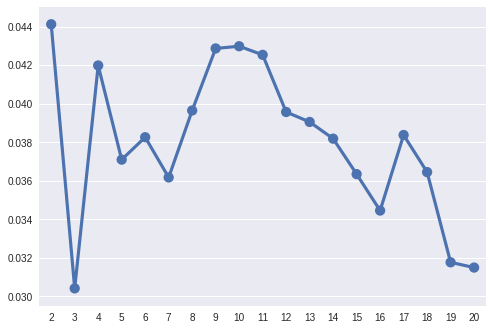

In [35]:
sns.pointplot(x_axis,y_axis)
# sns.pointplot(x_axis,z_axis,ax=ax2)
plt.show()

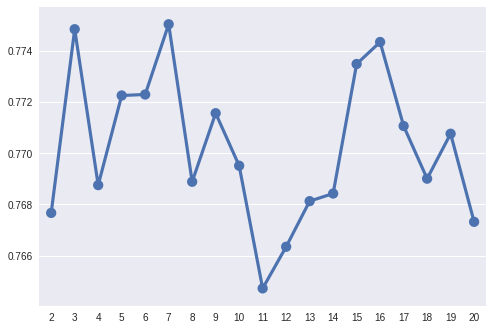

In [36]:
sns.pointplot(x_axis,z_axis)
plt.show()

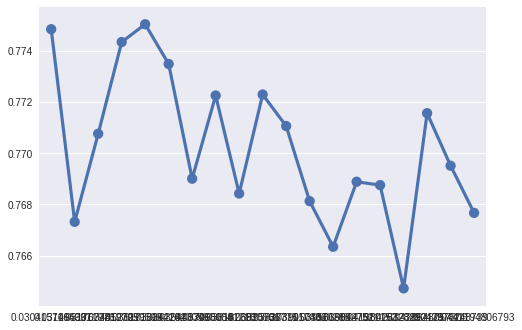

In [37]:
sns.pointplot(y_axis,z_axis)
plt.show()

In [38]:
metrics.r2_score(y_pred=reg_fit.predict(df_x),y_true=df_y)

0.85567249806861234

In [ ]:
get_final(reg_fit.predict(df_test_x)).to_csv("decision_tree_regression.csv",index=None)

### Random Forest Regressor

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [26]:
rfr = RandomForestRegressor()
params = {'max_depth': [20,30,40], 'n_estimators': [500], 'max_features': [100,140,160]} 
gsCV = GridSearchCV(estimator = rfr, param_grid = params, cv = 5, n_jobs = -1, verbose = 3,refit=True)

In [ ]:
gsCV.fit(df_x,df_y.values.ravel())

In [ ]:
print(gsCV.best_estimator_)

In [27]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)

In [28]:
rfr_n = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features=100, n_estimators=500, n_jobs=1,
           oob_score=True, random_state=None)
rfr_n.fit(df_x,df_y.values.ravel())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features=100, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [29]:
cv_score = cross_val_score(estimator=rfr_n, X=df_x, y=df_y.values.ravel(), cv = 10, n_jobs = -1)

In [30]:
np.mean(cv_score)

0.88542370223375211

In [31]:
metrics.r2_score(y_pred=rfr_n.predict(df_x),y_true=df_y)

0.98417163906310534

In [ ]:
df_test_x.shape

In [ ]:
get_final(rfr_n.predict(df_test_x)).to_csv("random_forest_regression.csv",index=None)

### Random Prediction - Inverse Transform Sampling

In [ ]:
np.histogram(df_y,bins=20)

In [ ]:
import scipy.interpolate as interpolate
 
def inverse_transform_sampling(data, n_bins=40, n_samples=1000):
    hist, bin_edges = np.histogram(data, bins=n_bins, density=True)
    cum_values = np.zeros(bin_edges.shape)
    cum_values[1:] = np.cumsum(hist*np.diff(bin_edges))
    inv_cdf = interpolate.interp1d(cum_values, bin_edges)
    r = np.random.rand(n_samples)
    return inv_cdf(r)

In [ ]:
df_submit['sale1'] = inverse_transform_sampling(np.log(df_y),n_bins=40,n_samples=1459)
df_submit['sale2'] = inverse_transform_sampling(np.log(df_y),n_bins=40,n_samples=1459)
df_submit['sale3'] = inverse_transform_sampling(np.log(df_y),n_bins=40,n_samples=1459)
df_submit['sale4'] = inverse_transform_sampling(np.log(df_y),n_bins=40,n_samples=1459)
df_submit['sale5'] = inverse_transform_sampling(np.log(df_y),n_bins=40,n_samples=1459)
df_submit['sale6'] = inverse_transform_sampling(np.log(df_y),n_bins=40,n_samples=1459)
df_submit['sale7'] = inverse_transform_sampling(np.log(df_y),n_bins=40,n_samples=1459)

In [ ]:
df_submit['SalePrice'] = np.exp(df_submit[['sale1','sale2','sale3','sale4','sale5','sale6','sale7']].mean(axis=1))

In [ ]:
df_submit[['Id','SalePrice']].to_csv("sub_random.csv",index=None)

### Unskew

In [ ]:
df_x['MSSubClass']

In [ ]:
df_x.skew()>25

In [ ]:
df_x.kurt()

### XGBoost

In [23]:
from xgboost.sklearn import XGBRegressor
from sklearn.grid_search import GridSearchCV
from sklearn import metrics

In [ ]:
params = {'learning_rate': [0.03,0.04,0.5], 'n_estimators': [500], 'max_depth': [3,4,5], 'colsample_bytree':[0.3,0.4,0.5]} 
gsCV = GridSearchCV(estimator = XGBRegressor(), param_grid = params, cv = 5, n_jobs = -1, verbose = 3,refit=True)

In [ ]:
gsCV.fit(df_x,df_y.values.ravel())

In [ ]:
print(gsCV.best_estimator_)

In [16]:
len(set(df_x.columns))

271

In [17]:
xgb = XGBRegressor(learning_rate=0.04,n_estimators=500,max_depth=3,colsample_bytree=0.4)
cv_score = cross_val_score(estimator=xgb, X=df_x, y=df_y, cv = 10, n_jobs = -1,scoring=sklearn.metrics)
xgb.fit(df_x,df_y)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.4,
       gamma=0, learning_rate=0.04, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=500, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [18]:
np.mean(cv_score)

0.91259777036196787

In [19]:
np.std(cv_score)

0.023143887748984196

In [24]:
metrics.r2_score(y_pred=xgb.predict(df_x),y_true=df_y)

0.96835276414708371

In [ ]:
get_final(xgb.predict(df_test_x)).to_csv("XGBoost.csv",index=None) 

In [ ]:
df_x

### Neural Network

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.callbacks import EarlyStopping
from keras import metrics

In [ ]:
# for i in range(0,256):
#     len(pd.DataFrame(df_x).iloc[1,:])
df_sample_y = inverse_transform_sampling(pd.DataFrame(df_y),40,14600)

In [ ]:
df_sample_y.shape

In [ ]:
inverse_transform_sampling()

In [ ]:
model = Sequential()

In [ ]:
model.add(Dense(600,activation='relu',input_shape=df_x[1,].shape))

In [ ]:
model.add(Dense(600,activation='relu'))

In [ ]:
model.add(Dense(600,activation='relu'))

In [ ]:
model.add(Dense(1))

In [ ]:
import keras.backend as K

def R2_Error(y_true,y_pred):
    

In [ ]:
from keras.optimizers import Adam

adam_opti = Adam(lr=0.0001,decay=0.80)

model.compile(optimizer=adam_opti,
             loss='mean_squared_error')

In [ ]:
es = EarlyStopping(monitor='loss',patience=5)

In [ ]:
x_train = np.array(df_x)
y_train = np.array(df_y)

In [ ]:
model.fit(df_x,df_y,validation_split=0.3,epochs=100,callbacks=[es])

In [ ]:
cross_val_score(estimator=rfr_n, X=df_x, y=df_y.values.ravel(), cv = 10, n_jobs = -1)
# model.predict(df_test_x)

In [ ]:
sub = get_final(pd.DataFrame(model.predict(df_x)))

In [ ]:
sub.to_csv("NN.csv",index=False)

In [ ]:
from sklearn import preprocessing

# std_scale = preprocessing.MinMaxScaler().fit(df_x)
# df_std = std_scale.transform(df_x)
minmax_scale = preprocessing.MinMaxScaler().fit(df_x)
df_minmax = minmax_scale.transform(df_x)

In [ ]:
df_minmax

In [ ]:
df_x.shape

In [ ]:
df_std.shape

In [ ]:
df_x.corr

### Elastic search

### Ensemble reports

In [59]:
ensmble = 0.94*xgb.predict(df_x) + 0.06*rfr_n.predict(df_x)

In [65]:
np.sqrt(metrics.mean_squared_error(y_pred=ensmble,y_true=df_y))

0.069054902021745551

In [61]:
metrics.r2_score(y_pred=ensmble,y_true=df_y)*100

97.009404487785673

In [62]:
get_final((xgb.predict(df_test_x)+rfr_n.predict(df_test_x))/2).to_csv("Mix-XG-RFR.csv",index=None) 

In [64]:
xgb.score(df_x,df_y)

0.96835276414708371